# IMPORT LIBRARIES AND DATASET

In [81]:
import pandas as pd
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import gensim
from gensim.corpora import Dictionary
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_fscore_support

# Download required NLTK resources
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Administrator\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [4]:
# Import the Excel data file
excel_file_path = "C:/Users/Administrator/desktop/bradford project/habeeb/habbeb data.xlsx"
data = pd.read_excel(excel_file_path)
# Display the data
print(data)

       S.No.                                             Review  Rating
0          1  nice hotel expensive parking got good deal sta...       4
1          2  ok nothing special charge diamond member hilto...       2
2          3  nice rooms not 4* experience hotel monaco seat...       3
3          4  unique \tgreat stay \twonderful time hotel mon...       5
4          5  great stay great stay \twent seahawk game awes...       5
...      ...                                                ...     ...
20486  20487  best kept secret 3rd time staying charm \tnot ...       5
20487  20488  great location price view hotel great quick pl...       4
20488  20489  ok just looks nice modern outside \tdesk staff...       2
20489  20490  hotel theft ruined vacation hotel opened sept ...       1
20490  20491  people talking \tca n't believe excellent rati...       2

[20491 rows x 3 columns]


In [5]:
# display the dataframe
data.head()

,S.No.,Review,Rating
0,1,nice hotel expensive parking got good deal sta...,4
1,2,ok nothing special charge diamond member hilto...,2
2,3,nice rooms not 4* experience hotel monaco seat...,3
3,4,unique \tgreat stay \twonderful time hotel mon...,5
4,5,great stay great stay \twent seahawk game awes...,5


In [6]:
data.info

<bound method DataFrame.info of        S.No.                                             Review  Rating
0          1  nice hotel expensive parking got good deal sta...       4
1          2  ok nothing special charge diamond member hilto...       2
2          3  nice rooms not 4* experience hotel monaco seat...       3
3          4  unique \tgreat stay \twonderful time hotel mon...       5
4          5  great stay great stay \twent seahawk game awes...       5
...      ...                                                ...     ...
20486  20487  best kept secret 3rd time staying charm \tnot ...       5
20487  20488  great location price view hotel great quick pl...       4
20488  20489  ok just looks nice modern outside \tdesk staff...       2
20489  20490  hotel theft ruined vacation hotel opened sept ...       1
20490  20491  people talking \tca n't believe excellent rati...       2

[20491 rows x 3 columns]>

In [8]:
data.shape

(20491, 3)

In [11]:
# Display summary statistics for the numerical column(s)
print("Summary Statistics:")
print(data.describe())  
print()

Summary Statistics:
              S.No.        Rating
count  20491.000000  20491.000000
mean   10246.000000      3.952223
std     5915.386519      1.233030
min        1.000000      1.000000
25%     5123.500000      3.000000
50%    10246.000000      4.000000
75%    15368.500000      5.000000
max    20491.000000      5.000000



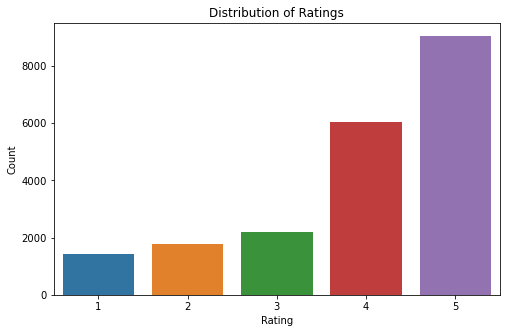

In [16]:
# Distribution of ratings
plt.figure(figsize=(8, 5))
sns.countplot(x='Rating', data=data)  
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

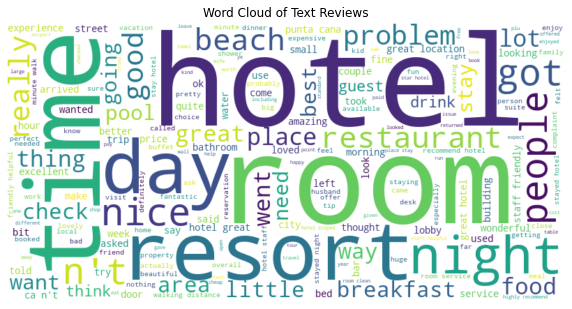

In [20]:
#Combine all the text_reviews into a single string
all_reviews_text = " ".join(review for review in data['Review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Text Reviews')
plt.show()

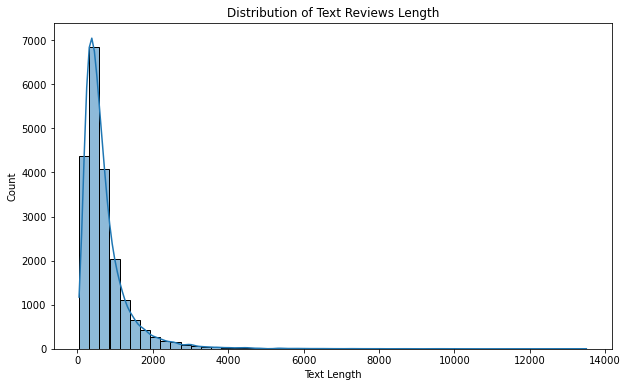

In [24]:
#Text reviews length distribution
data['text_length'] = data['Review'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='text_length', bins=50, kde=True)
plt.title('Distribution of Text Reviews Length')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

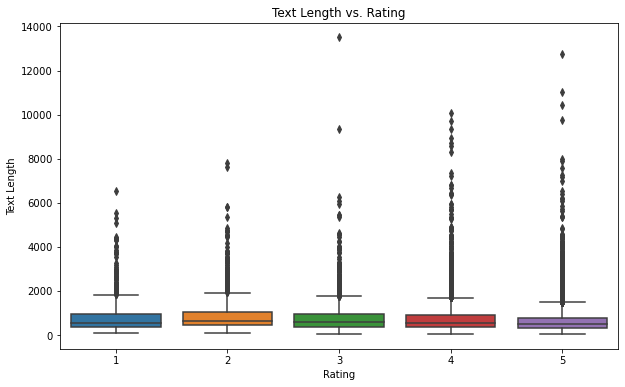

In [26]:
#Explore any patterns between text length and ratings
plt.figure(figsize=(10, 6))
sns.boxplot(x='Rating', y='text_length', data=data)
plt.title('Text Length vs. Rating')
plt.xlabel('Rating')
plt.ylabel('Text Length')
plt.show()

# PREPROCESSING DATASET

In [32]:
# Function to preprocess the Review
def preprocess_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove special characters and digits using regular expression
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Tokenization
    words = word_tokenize(text)

    # Stopword removal
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]

    # Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the processed words back into a sentence
    processed_text = " ".join(words)

    return processed_text

# Apply preprocessing to the 'Review' column
data['processed_reviews'] = data['Review'].apply(preprocess_text)

# Display the preprocessed Review
print("Preprocessed Text Reviews:")
print(data['processed_reviews'].head())

Preprocessed Text Reviews:
0    nice hotel expens park got good deal stay hote...
1    ok noth special charg diamond member hilton de...
2    nice room experi hotel monaco seattl good hote...
3    uniqu great stay wonder time hotel monaco loca...
4    great stay great stay went seahawk game awesom...
Name: processed_reviews, dtype: object


# INSIGHT AND FINDINGS

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


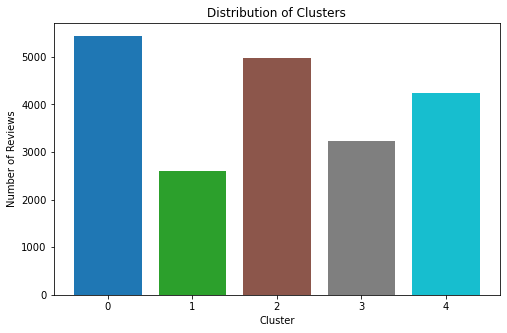

In [45]:
#CLUSTERS BASED ON TEXT SIMILARITIES 

# Get the processed reviews from the data
processed_reviews = data['processed_reviews']

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust the max_features based on your data size

# Fit and transform the processed reviews to obtain TF-IDF features
tfidf_matrix = vectorizer.fit_transform(processed_reviews)

# Apply K-Means clustering
num_clusters = 5  # You can adjust the number of clusters based on your requirements
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
clusters = kmeans.fit_predict(tfidf_matrix)

# Add the cluster labels to the data
data['cluster'] = clusters

# Get the number of reviews in each cluster
cluster_counts = data['cluster'].value_counts().sort_index()

# Plot the distribution of clusters with different colors
plt.figure(figsize=(8, 5))
colors = plt.cm.tab10(np.linspace(0, 1, num_clusters))  # Generate distinct colors from the 'tab10' colormap
plt.bar(cluster_counts.index, cluster_counts.values, color=colors)
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.title('Distribution of Clusters')
plt.show()

In [48]:
#SENTIMENTS-BASED SEGMENTATION

def sentiment_based_segmentation(data):
    # Categorize reviews into positive, neutral, and negative sentiments based on Rating
    data['sentiment'] = data['Rating'].apply(lambda x: 'Positive' if x > 3 else 'Neutral' if x == 3 else 'Negative')

    # Group reviews by sentiment
    sentiment_segments = data.groupby('sentiment')['processed_reviews'].apply(list).reset_index(name='reviews')

    return sentiment_segments

# Perform Sentiment-Based Segmentation
segmented_data = sentiment_based_segmentation(data)

# Display the segments
print("Sentiment-Based Segmentation:")
print(segmented_data)

Sentiment-Based Segmentation:
  sentiment                                            reviews
0  Negative  [ok noth special charg diamond member hilton d...
1   Neutral  [nice room experi hotel monaco seattl good hot...
2  Positive  [nice hotel expens park got good deal stay hot...


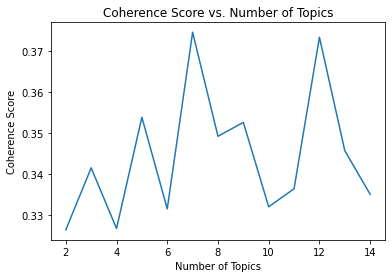

Topics and their top words:
Topic 1: 0.043*"hotel" + 0.023*"barcelona" + 0.016*"book" + 0.012*"room" + 0.012*"stay" + 0.010*"charg" + 0.009*"told" + 0.009*"night" + 0.009*"day" + 0.008*"card"
Topic 2: 0.028*"room" + 0.012*"day" + 0.012*"n" + 0.011*"hotel" + 0.009*"servic" + 0.009*"staff" + 0.008*"check" + 0.007*"time" + 0.006*"stay" + 0.006*"ask"
Topic 3: 0.015*"hotel" + 0.014*"room" + 0.012*"n" + 0.012*"nice" + 0.011*"stay" + 0.011*"good" + 0.010*"great" + 0.010*"time" + 0.009*"day" + 0.008*"night"
Topic 4: 0.042*"room" + 0.031*"hotel" + 0.014*"stay" + 0.010*"night" + 0.010*"good" + 0.010*"n" + 0.009*"locat" + 0.008*"bathroom" + 0.008*"floor" + 0.008*"bed"
Topic 5: 0.053*"hotel" + 0.024*"stay" + 0.023*"room" + 0.020*"great" + 0.015*"locat" + 0.015*"staff" + 0.010*"good" + 0.010*"walk" + 0.009*"breakfast" + 0.009*"help"
Topic 6: 0.020*"beach" + 0.017*"resort" + 0.015*"pool" + 0.013*"food" + 0.011*"great" + 0.011*"time" + 0.010*"n" + 0.009*"good" + 0.008*"day" + 0.008*"restaur"
Topic 7:

In [50]:
#TOPIC MODELING
# Create a list of tokenized documents from the 'processed_reviews' column
documents = [review.split() for review in data['processed_reviews']]

# Create a dictionary and corpus
dictionary = Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

# Function to find the optimal number of topics using coherence score
def find_optimal_num_topics(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        coherence_values.append(coherence_score)

    return coherence_values

# Find the optimal number of topics based on coherence score
limit = 15
start = 2
step = 1
coherence_values = find_optimal_num_topics(dictionary, corpus, documents, limit, start, step)

# Plot the coherence scores to identify the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs. Number of Topics")
plt.show()

# Choose the number of topics with the highest coherence score
optimal_num_topics = x[coherence_values.index(max(coherence_values))]

# Perform topic modeling with the optimal number of topics
lda_model = LdaModel(corpus=corpus, num_topics=optimal_num_topics, id2word=dictionary)

# Print the topics and their top words
print("Topics and their top words:")
topics = lda_model.show_topics(num_topics=-1, num_words=10)
for topic_num, words in topics:
    print(f"Topic {topic_num + 1}: {words}")

In [53]:
#RATING-BASED SEGMENTATION
def rating_based_segmentation(data):
    # Categorize customers into different segments based on their Rating
    positive_reviews = data[data['Rating'] > 3]
    neutral_reviews = data[data['Rating'] == 3]
    negative_reviews = data[data['Rating'] < 3]

    # Count the number of unique processed reviews in each segment
    num_positive_reviews = len(positive_reviews['processed_reviews'].unique())
    num_neutral_reviews = len(neutral_reviews['processed_reviews'].unique())
    num_negative_reviews = len(negative_reviews['processed_reviews'].unique())

    # Calculate the percentage of each segment
    total_reviews = num_positive_reviews + num_neutral_reviews + num_negative_reviews
    percentage_positive = (num_positive_reviews / total_reviews) * 100
    percentage_neutral = (num_neutral_reviews / total_reviews) * 100
    percentage_negative = (num_negative_reviews / total_reviews) * 100

    return percentage_positive, percentage_neutral, percentage_negative

# Perform rating-based segmentation
percentage_positive, percentage_neutral, percentage_negative = rating_based_segmentation(data)

print(f"Percentage of customers who left positive reviews: {percentage_positive:.2f}%")
print(f"Percentage of customers who left neutral reviews: {percentage_neutral:.2f}%")
print(f"Percentage of customers who left negative reviews: {percentage_negative:.2f}%")

Percentage of customers who left positive reviews: 73.66%
Percentage of customers who left neutral reviews: 10.66%
Percentage of customers who left negative reviews: 15.68%


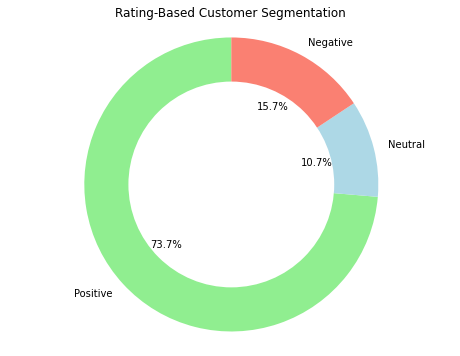

In [85]:
# Plot the donut chart
plt.figure(figsize=(8, 6))
segments = ['Positive', 'Neutral', 'Negative']
sizes = [percentage_positive, percentage_neutral, percentage_negative]
colors = ['lightgreen', 'lightblue', 'salmon']
plt.pie(sizes, colors=colors, labels=segments, autopct='%1.1f%%', startangle=90)
# Draw a white circle at the center to create the donut effect
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.axis('equal')
plt.title('Rating-Based Customer Segmentation')
plt.show()

In [56]:
#KEYWAORD-BASED SEGMENTATION
def keyword_based_segmentation(data, keyword_dict):
    # Create an empty dictionary to store the counts for each segment
    segment_counts = {segment: 0 for segment in keyword_dict.keys()}

    # Iterate through the processed reviews and categorize them into segments based on keywords
    for review in data['processed_reviews'].unique():
        for segment, keywords in keyword_dict.items():
            for keyword in keywords:
                if keyword in review:
                    segment_counts[segment] += 1
                    break  # Exit the loop after finding the first matching keyword

    # Calculate the total number of reviews (processed reviews are unique)
    total_reviews = len(data['processed_reviews'].unique())

    # Calculate the percentage of each segment
    percentage_segments = {segment: (count / total_reviews) * 100 for segment, count in segment_counts.items()}

    return percentage_segments

# Define the keywords for each segment
keyword_dict = {
    'segment_1': ['positive', 'great', 'excellent', 'fantastic', 'wonderful'],
    'segment_2': ['neutral', 'average', 'ok', 'satisfactory'],
    'segment_3': ['negative', 'poor', 'bad', 'disappointing', 'awful']
}

# Perform keyword-based segmentation
percentage_segments = keyword_based_segmentation(data, keyword_dict)

# Print the percentage of each segment
for segment, percentage in percentage_segments.items():
    print(f"Percentage of customers in {segment}: {percentage:.2f}%")

Percentage of customers in segment_1: 54.97%
Percentage of customers in segment_2: 56.47%
Percentage of customers in segment_3: 14.85%


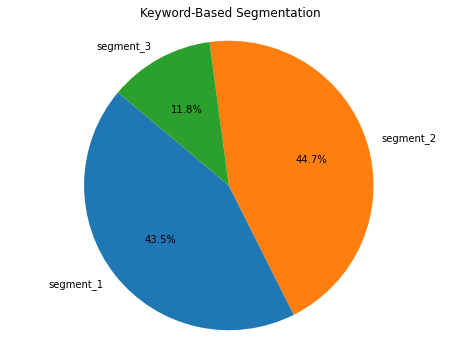

In [87]:
# Plot the results as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(list(percentage_segments.values()), labels=list(percentage_segments.keys()), autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.title('Keyword-Based Segmentation')
plt.show()

# PREDICTING REVIEWS

In [59]:
#AGGREGRATE PREDICTION
def aggregate_sentiment_predictions(data):
    # Categorize customers into different segments based on their Rating
    positive_reviews = data[data['Rating'] > 3]
    neutral_reviews = data[data['Rating'] == 3]
    negative_reviews = data[data['Rating'] < 3]

    # Calculate the overall sentiment score for each segment
    positive_sentiment_score = np.mean(positive_reviews['Rating'])
    neutral_sentiment_score = np.mean(neutral_reviews['Rating'])
    negative_sentiment_score = np.mean(negative_reviews['Rating'])

    # Determine the sentiment label for each segment
    sentiment_labels = {
        'positive': 'Positive',
        'neutral': 'Neutral',
        'negative': 'Negative'
    }

    # Predict the overall sentiment label for each segment
    overall_sentiment = {
        'positive': sentiment_labels['positive'] if positive_sentiment_score >= 3 else sentiment_labels['negative'],
        'neutral': sentiment_labels['neutral'],
        'negative': sentiment_labels['negative'] if negative_sentiment_score <= 3 else sentiment_labels['positive']
    }

    return overall_sentiment

# Perform aggregated predictions on sentiment
overall_sentiment = aggregate_sentiment_predictions(data)

# Print the overall sentiment for each segment
for segment, sentiment in overall_sentiment.items():
    print(f"Overall sentiment for {segment} reviews: {sentiment}")

Overall sentiment for positive reviews: Positive
Overall sentiment for neutral reviews: Neutral
Overall sentiment for negative reviews: Negative


In [61]:
#TOPIC PREDICTION
def topic_prediction(data, num_topics):
    # Create a list of tokenized documents from the 'processed_reviews' column
    documents = [review.split() for review in data['processed_reviews']]

    # Create a dictionary and corpus
    dictionary = Dictionary(documents)
    corpus = [dictionary.doc2bow(doc) for doc in documents]

    # Perform topic modeling using LDA
    lda_model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10)

    # Get the most significant words for each topic
    topics = lda_model.show_topics(num_topics=num_topics, num_words=10)

    return topics

# Define the number of topics you want to identify
num_topics = 5

# Perform topic prediction
topics = topic_prediction(data, num_topics)

# Print the topics and their top words
for topic_num, words in topics:
    print(f"Topic {topic_num + 1}: {words}")

Topic 1: 0.057*"hotel" + 0.027*"room" + 0.025*"stay" + 0.022*"great" + 0.019*"locat" + 0.015*"staff" + 0.014*"good" + 0.012*"walk" + 0.011*"breakfast" + 0.010*"clean"
Topic 2: 0.039*"room" + 0.029*"hotel" + 0.014*"n" + 0.013*"stay" + 0.009*"night" + 0.007*"check" + 0.007*"bed" + 0.007*"servic" + 0.006*"day" + 0.006*"time"
Topic 3: 0.016*"resort" + 0.014*"beach" + 0.013*"n" + 0.012*"time" + 0.012*"great" + 0.012*"food" + 0.011*"day" + 0.010*"room" + 0.010*"good" + 0.008*"peopl"
Topic 4: 0.016*"park" + 0.012*"breakfast" + 0.012*"great" + 0.012*"car" + 0.011*"free" + 0.011*"stay" + 0.009*"hotel" + 0.009*"bali" + 0.009*"nice" + 0.008*"walk"
Topic 5: 0.028*"pool" + 0.016*"beach" + 0.014*"water" + 0.013*"bar" + 0.011*"restaur" + 0.010*"food" + 0.009*"drink" + 0.009*"kid" + 0.008*"area" + 0.007*"good"


In [62]:
#FEEDBACK ANALYSIS
def feedback_analysis(data, keyword_dict):
    # Create an empty dictionary to store the counts for each feedback category
    feedback_counts = {category: 0 for category in keyword_dict.keys()}

    # Iterate through the processed reviews and classify them into feedback categories based on keywords
    for review in data['processed_reviews']:
        for category, keywords in keyword_dict.items():
            for keyword in keywords:
                if keyword in review:
                    feedback_counts[category] += 1
                    break  # Exit the loop after finding the first matching keyword

    return feedback_counts

# Define the keywords for each feedback category
keyword_dict = {
    'complaints': ['problem', 'issue', 'disappointing', 'poor', 'bad'],
    'suggestions': ['suggest', 'improve', 'recommend', 'enhance'],
    'praises': ['excellent', 'wonderful', 'fantastic', 'great', 'amazing']
}

# Perform feedback analysis
feedback_counts = feedback_analysis(data, keyword_dict)

# Print the counts for each feedback category
for category, count in feedback_counts.items():
    print(f"Number of reviews in {category} category: {count}")

Number of reviews in complaints category: 5495
Number of reviews in suggestions category: 6020
Number of reviews in praises category: 11312


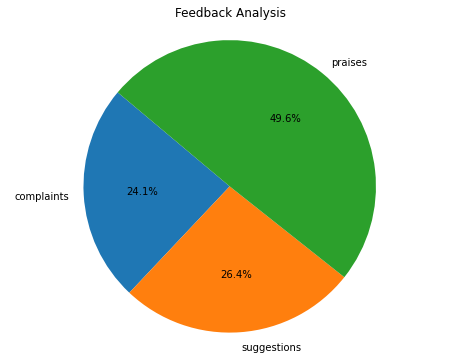

In [66]:
# Convert the feedback counts dictionary to lists for plotting
categories = list(feedback_counts.keys())
counts = list(feedback_counts.values())

# Plot the results as a pie chart
plt.figure(figsize=(8, 6))
plt.pie(counts, labels=categories, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that the pie chart is drawn as a circle.
plt.title('Feedback Analysis')
plt.show()

In [70]:
def nlp_based_predictions(data, keyword_dict):
    # Create a list of tokenized documents from the 'processed_reviews' column
    documents = [review for review in data['processed_reviews']]

    # Create a CountVectorizer with specified keywords as features
    vectorizer = CountVectorizer(vocabulary=keyword_dict.keys())

    # Extract features (word frequencies) from the reviews
    X = vectorizer.fit_transform(documents)
    y = data['Rating'].apply(lambda rating: 'positive' if rating > 3 else 'negative' if rating < 3 else 'neutral')

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build a Naive Bayes classifier
    classifier = MultinomialNB()
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Calculate accuracy and print classification report
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    return accuracy, report

# Define the keywords for each sentiment category (positive, neutral, and negative)
keyword_dict = {
    'positive': ['positive', 'great', 'excellent', 'fantastic', 'wonderful'],
    'neutral': ['neutral', 'average', 'ok', 'satisfactory'],
    'negative': ['negative', 'poor', 'bad', 'disappointing', 'awful']
}

# Perform NLP-based predictions
accuracy, classification_report = nlp_based_predictions(data, keyword_dict)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report)

Accuracy: 0.74
Classification Report:
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00       625
     neutral       0.00      0.00      0.00       432
    positive       0.74      1.00      0.85      3042

    accuracy                           0.74      4099
   macro avg       0.25      0.33      0.28      4099
weighted avg       0.55      0.74      0.63      4099



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


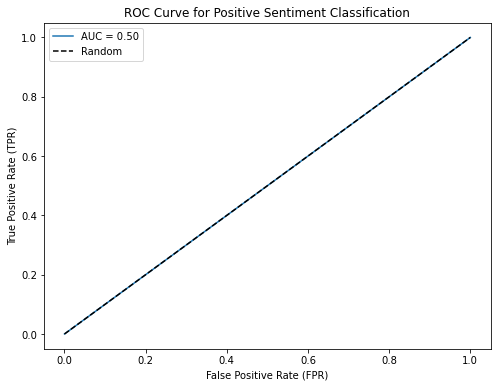

In [80]:
#ROC CURVE
def nlp_based_predictions(data, keyword_dict):
    # Create a list of tokenized documents from the 'processed_reviews' column
    documents = [review for review in data['processed_reviews']]

    # Create a CountVectorizer with specified keywords as features
    vectorizer = CountVectorizer(vocabulary=keyword_dict.keys())

    # Extract features (word frequencies) from the reviews
    X = vectorizer.fit_transform(documents)
    y = data['Rating'].apply(lambda rating: 1 if rating > 3 else 0)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Build a Naive Bayes classifier
    classifier = MultinomialNB()
    classifier.fit(X_train, y_train)

    # Make probability predictions on the test set
    y_prob = classifier.predict_proba(X_test)[:, 1]

    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate the AUC score
    auc_score = roc_auc_score(y_test, y_prob)

    return fpr, tpr, auc_score

# Define the keywords for positive sentiment
positive_keywords = ['positive', 'great', 'excellent', 'fantastic', 'wonderful']

# Perform NLP-based predictions and ROC curve analysis
fpr, tpr, auc_score = nlp_based_predictions(data, {'positive': positive_keywords})

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.2f}')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Positive Sentiment Classification')
plt.legend()
plt.show()